# Building a Vegan Likelihood Model

The goal is to build a model to either predict if a dish is vegan just from the recipe name, or create a scoring model to predict how likely or easily a recipe is or could be vegan.

Or rather, we can take the cosine similarity with a user input for a recipe name and out list of recipes from out database, and then use the top score to get the list of ingredients. Then our model can predict how likely the recipe would be vegan. Could just also list out potentially ingredients that would likely show up as non-vegan in this recipe to watch out for.

## EDA and Pre-processing

In [1]:
import pandas as pd
import ast

In [25]:
df = pd.read_csv('example_recipes.csv')

In [26]:
df.columns

Index(['uri', 'label', 'image', 'source', 'url', 'shareAs', 'yield',
       'dietLabels', 'healthLabels', 'cautions', 'ingredientLines',
       'ingredients', 'calories', 'totalWeight', 'totalTime', 'cuisineType',
       'mealType', 'dishType', 'totalNutrients', 'totalDaily', 'digest',
       'tags'],
      dtype='object')

In [27]:
ingredients_col = df['ingredients'].apply(ast.literal_eval)

In [28]:
ingredients_col[1][0]

{'text': '375g/13oz plain flour',
 'quantity': 375.0,
 'measure': 'gram',
 'food': 'flour',
 'weight': 375.0,
 'foodCategory': 'grains',
 'foodId': 'food_ahebfs0a985an4aubqaebbipra58',
 'image': 'https://www.edamam.com/food-img/b4c/b4c739e76a6f2172b7ad49d0aa41d5aa.jpg'}

In [29]:
dct = dict()
dct.keys()

dict_keys([])

In [30]:
#ingredients_col[1][0]['foodCategory']
dct[ingredients_col[1][0]['foodCategory']] = ingredients_col[1][0]['quantity']

In [31]:
dct = dict()
for i, row in ingredients_col.items():
    for j in range(len(row)):
        key = row[j]['foodCategory']
        value = row[j]['quantity']

        if key in dct.keys():
            dct[key] += value
        else:
            dct[key] = value

In [32]:
'text' in ingredients_col[0][0]

True

In [33]:
dct.keys()

dict_keys(['Eggs', 'Milk', 'Cheese', 'Dairy', 'grains', 'Condiments and sauces', 'condiments and sauces', 'Oils', 'vegetables', 'canned vegetables', 'milk', 'bread, rolls and tortillas', 'cured meats', 'fruit', 'canned grains', 'canned soup', 'bov', 'plant-based protein', 'sugars', 'quick breads and pastries', 'wines', '100% juice', 'water', 'yogurt', 'beer', 'ready-to-eat cereals', 'sugar syrups', 'Cured meats', 'crackers', 'savory snacks', 'liquors and cocktails', 'meats', 'sugar jam', 'Vegan products', 'candy', 'chocolate', None, 'canned fruit', 'non-dairy beverages', 'flavored water', 'cocktails and liquors', 'canned seafood', 'seafood', 'Poultry', 'sweetened beverages', 'pastries', 'frozen treats', 'coffee and tea', 'eggs', 'cooked grains', 'Plant-based protein', 'frozen grained based', 'mixed grains', 'sandwhiches', 'protein and nutritional powders', 'salads'])

In [34]:
ex_s = ''
ex_s_lst = ast.literal_eval(df.iloc[0]['ingredientLines'])
for s in ex_s_lst:
    ex_s += s + ', '

ex_s

'1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil, '

In [35]:
', '.join(ex_s_lst)

'1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil'

## Preprocessing for Transformer

Going to try to preprocess data to take the dish/recipe name (`label` column) and the `healthLabel` as input, and output the ingredients list as a long string. We can use a transformer for this to output the recipe's ingredients in long text form. 

The `healthLabel` will only be a select few options though, and the user can only select 1 for now, from: ['Mediterranean', 'Vegetarian', 'Vegan', 'Red-Meat-Free', 'Paleo', 'Pescatarian']. When reducing the healthLabels column from multilabel to categorical, we need to define a priority order, and if none of these are there then the dish is balanced, so we will add that as an option. In the future, some analysis on this column should be done to improve the priority order, rather than relying on domain knowledge. Alternatively, and option to select multiple could be implemented instead.

In [36]:
priority_order = ['Vegan', 'Vegetarian', 'Pescatarian', 'Paleo', 'Red-Meat-Free', 'Mediterranean']

In [37]:
health_labels = df['healthLabels'].apply(ast.literal_eval)
health_labels

0       [Sugar-Conscious, Low Potassium, Kidney-Friend...
1       [Sugar-Conscious, Low Potassium, Kidney-Friend...
2       [Sugar-Conscious, Low Potassium, Kidney-Friend...
3       [Sugar-Conscious, Low Potassium, Kidney-Friend...
4       [Vegetarian, Pescatarian, Egg-Free, Peanut-Fre...
                              ...                        
1195    [Keto-Friendly, Pescatarian, Mediterranean, Gl...
1196    [Pescatarian, Gluten-Free, Wheat-Free, Egg-Fre...
1197    [Sugar-Conscious, Keto-Friendly, Pescatarian, ...
1198    [Sugar-Conscious, Keto-Friendly, Pescatarian, ...
1199    [Sugar-Conscious, Pescatarian, Mediterranean, ...
Name: healthLabels, Length: 1200, dtype: object

In [38]:
def replace_with_priority(labels):
    for label in priority_order:
        if label in labels:
            return label
    return 'Balanced'  # Handle case where no label matches priority_order, in which case the diet is balanced

# Apply function to the multilabels series
diet_type = health_labels.apply(replace_with_priority)

In [39]:
diet_type.value_counts()

healthLabels
Vegetarian       400
Vegan            279
Pescatarian      209
Balanced         181
Red-Meat-Free     57
Paleo             42
Mediterranean     32
Name: count, dtype: int64

Now we have our dietary preference column. The recipe name is fine as is so next is the ingredients list which is our target variable.

In [40]:
recipe_name = df['label']

We need to just join these lists of strings with commas so they be user friendly to read. 

In [41]:
ingredients_lst = df['ingredientLines'].apply(ast.literal_eval)
ingredients_lst = ingredients_lst.apply(lambda x: ', '.join(x))
ingredients_lst

0       1 organic large egg, 1 teaspoon whole milk or ...
1       375g/13oz plain flour, Pinch salt, 225g/8oz bu...
2       1 cup asiago cheese, grated, 1 cup fontina che...
3       4 ounces, weight Cream Cheese, Softened, 1/2 c...
4       8 ounces elbow pasta, 1/4 cup unsalted butter,...
                              ...                        
1195    4 (6 ounce) tilapia fillets, salt, pepper, 1/2...
1196    * 1 Vegetable oil cooking spray, * 4 U.S.-farm...
1197    2 tbsp chopped red onion, 1 tbsp olive oil, 1 ...
1198    3 tablespoons unsalted butter, 2 tablespoons e...
1199    * 2 tilapia fillets (skinless, about 4 ounces ...
Name: ingredientLines, Length: 1200, dtype: object

Now we can make our dataframe for the modeling.

In [42]:
df2 = pd.concat([diet_type, recipe_name, ingredients_lst], axis = 1)
column_names = {'healthLabels': 'dietType', 'label': 'recipeName', 'ingredientLines': 'ingredientsList'}
df2 = df2.rename(columns=column_names)
df2.head()

,dietType,recipeName,ingredientsList
0,Vegetarian,Cheese Omelette,"1 organic large egg, 1 teaspoon whole milk or ..."
1,Vegetarian,Cheese straws,"375g/13oz plain flour, Pinch salt, 225g/8oz bu..."
2,Vegetarian,CHEESE GOOP,"1 cup asiago cheese, grated, 1 cup fontina che..."
3,Vegetarian,Pimento Cheese,"4 ounces, weight Cream Cheese, Softened, 1/2 c..."
4,Vegetarian,Five Cheese Skillet Mac and Cheese recipes,"8 ounces elbow pasta, 1/4 cup unsalted butter,..."


In [43]:
df2.to_csv('preprocessed_recipes_context_q&a.csv', index=False)

In [20]:
# models (transformers) can't handle tabular data well so we concatenate input columns, but use df3 for context Q and A modeling
df3 = pd.concat([df2['dietType'] + ' ' + df2['recipeName'], df2['ingredientsList']], axis = 1)
df3 = df3.rename(columns={0: 'recipeTypeName'})
df3.head(3)

,recipeTypeName,ingredientsList
0,Vegetarian Cheese Omelette,"1 organic large egg, 1 teaspoon whole milk or ..."
1,Vegetarian Cheese straws,"375g/13oz plain flour, Pinch salt, 225g/8oz bu..."
2,Vegetarian CHEESE GOOP,"1 cup asiago cheese, grated, 1 cup fontina che..."


In [21]:
df3.to_csv('preprocessed_example_recipes.csv', index=False)

## Modeling

### Hugging Face

### TensorFlow

Adapting this notebook: https://colab.research.google.com/github/snapthat/TF-T5-text-to-text/blob/master/snapthatT5/notebooks/TF-T5-Datasets%20Training.ipynb#scrollTo=dEutWnhiWRAq

In [68]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
from transformers import AutoTokenizer, TFT5ForConditionalGeneration
import datetime
import os
%load_ext tensorboard

tf_version = tf.__version__
print("Tensorflow: ", tf_version)
print("Transformers: ", transformers.__version__)
print("Datasets: ", datasets.__version__)

[]
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Tensorflow:  2.13.1
Transformers:  4.34.1
Datasets:  2.12.0


In [69]:
tf_version_split = tf_version.split('.')
assert int(tf_version_split[0])==2 and int(tf_version_split[-2])>=3, f"Tensorflow version should be '2.3+,x', given {tf_version}"

In [70]:
!mkdir data

data_dir = "./data"
log_dir = f"{data_dir}/experiments/t5/logs"
save_path = f"{data_dir}/experiments/t5/models"
cache_path_train = f"{data_dir}/cache/t5.train"
cache_path_test = f"{data_dir}/cache/t5.test"

A subdirectory or file data already exists.


In [110]:
warmup_steps = 1e4
batch_size = 4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000
ntrain = len(train_dataset)
nvalid = len(valid_dataset)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

class SnapthatT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss') 
    
    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}

Total Steps:  270
Total Validation Steps:  30


In [72]:
tokenizer = AutoTokenizer.from_pretrained("t5-base", model_max_length=1024)

In [24]:
dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/RaviB/.cache/huggingface/datasets/csv/default-5a626df6418d8a4d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
#train_dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv', split="train")
#valid_dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv', split='validation')

In [42]:
train_dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv', split="train[:90%]")
valid_dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv', split='train[90%:]')

Found cached dataset csv (C:/Users/RaviB/.cache/huggingface/datasets/csv/default-5a626df6418d8a4d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (C:/Users/RaviB/.cache/huggingface/datasets/csv/default-5a626df6418d8a4d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


In [48]:
train_dataset.features

{'recipeTypeName': Value(dtype='string', id=None),
 'ingredientsList': Value(dtype='string', id=None)}

In [46]:
data = next(iter(train_dataset))
print("Example data from the dataset: \n", data)

Example data from the dataset: 
 {'recipeTypeName': 'Vegetarian Cheese Omelette', 'ingredientsList': '1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil'}


In [53]:
a = list(['Saint Bernadette Soubirous'])
', '.join([i for i in list(a)])

'Saint Bernadette Soubirous'

In [59]:
s = list(['1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil'])
print(s)
s = ', '.join([i for i in list(s)])
print(s)
f"{s} </s>"

['1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil']
1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil


'1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil </s>'

In [63]:
def encode(example, encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):
  

    recipe_type_and_name = example['recipeTypeName']
    ingredients = example['ingredientsList']
    
    #context = example['context']
    question_plus = recipe_type_and_name
    answer = list([ingredients])
  
    #question_plus = f"answer_me: {str(question)}"
    question_plus += " </s>"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus} </s>"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                               pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                               pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention}
    return outputs

In [73]:
train_ds=  train_dataset.map(encode)
valid_ds=  valid_dataset.map(encode)

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

C:\Users\RaviB\AppData\Roaming\Python\Python39\site-packages\transformers\tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

In [74]:
ex = next(iter(train_ds))
print("Example data from the mapped dataset: \n", ex)

Example data from the mapped dataset: 
 {'recipeTypeName': 'Vegetarian Cheese Omelette', 'ingredientsList': '1 organic large egg, 1 teaspoon whole milk or water, 1 tablespoon cheddar cheese, shredded (you can use other types of cheese), 1 teaspoon butter or oil', 'input_ids': [3901, 2782, 6855, 21060, 13285, 15, 15529, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [75]:
def to_tf_dataset(dataset):  
  columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
  dataset.set_format(type='tensorflow', columns=columns)
  return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,  }
  return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None])}
  ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
  return ds

In [76]:
tf_train_ds = to_tf_dataset(train_ds)
tf_valid_ds = to_tf_dataset(valid_ds)

In [77]:
def create_dataset(dataset, cache_path=None, batch_size=4, 
                   buffer_size= 1000, shuffling=True):    
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [78]:
tf_train_ds= create_dataset(tf_train_ds, batch_size=batch_size, 
                         shuffling=True, cache_path = None)
tf_valid_ds = create_dataset(tf_valid_ds, batch_size=batch_size, 
                         shuffling=False, cache_path = None)

In [79]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps=1e4):
    super().__init__()

    self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    
  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    m = tf.maximum(self.warmup_steps, step)
    m = tf.cast(m, tf.float32)
    lr = tf.math.rsqrt(m)
    
    return lr 

Text(0, 0.5, 'Learning rate')

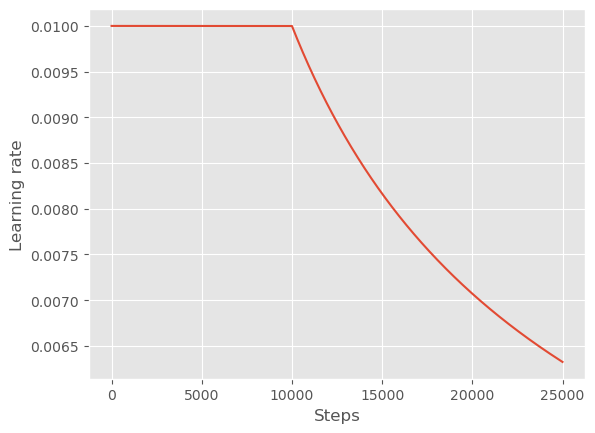

In [80]:
plt.style.use('ggplot')
schedule = CustomSchedule()
plt.plot(schedule(tf.range(25000, dtype=tf.float32)))
plt.xlabel("Steps")
plt.ylabel("Learning rate")

In [111]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_path + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback] 
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy') ]

In [112]:
#learning_rate = CustomSchedule()
learning_rate = 0.001  # Instead set a static learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate)

In [113]:
model = SnapthatT5.from_pretrained("t5-base")

All PyTorch model weights were used when initializing SnapthatT5.

Some weights or buffers of the TF 2.0 model SnapthatT5 were not initialized from the PyTorch model and are newly initialized: ['total', 'count']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
model.compile(optimizer=optimizer, metrics=metrics)

In [115]:
#%tensorboard --logdir ./data/experiments/t5/logs

In [116]:
epochs_done = 0
model.fit(tf_train_ds, epochs=2, validation_data=tf_valid_ds)

Epoch 1/2
     74/Unknown - 378s 5s/step - accuracy: 0.6969 - loss: 2.7471 - lr: 0.0010

KeyboardInterrupt: 

### PyTorch

Trying the above with pytorch since TensorFlow doesn't support windows when using GPUs anymore. Following along with https://huggingface.co/docs/transformers/tasks/question_answering to make sure it works.

In [1]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use GPU.")
    # Additional information
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))  # 0 is the GPU index
else:
    print("CUDA is not available. PyTorch will use CPU.")

CUDA is available! PyTorch can use GPU.
Number of CUDA devices: 1
CUDA device name: NVIDIA GeForce RTX 3060


In [2]:
#dataset = load_dataset("csv", data_files='preprocessed_example_recipes.csv')

In [4]:
squad = load_dataset("squad", split="train[:5000]")
squad = squad.train_test_split(test_size=0.2)
#train_dataset = load_dataset('squad', split='train')
#valid_dataset = load_dataset('squad', split='validation')

In [5]:
squad["train"][1]

{'id': '56d4c1452ccc5a1400d831dc',
 'title': 'Beyoncé',
 'context': 'At the 52nd Annual Grammy Awards, Beyoncé received ten nominations, including Album of the Year for I Am... Sasha Fierce, Record of the Year for "Halo", and Song of the Year for "Single Ladies (Put a Ring on It)", among others. She tied with Lauryn Hill for most Grammy nominations in a single year by a female artist. In 2010, Beyoncé was featured on Lady Gaga\'s single "Telephone" and its music video. The song topped the US Pop Songs chart, becoming the sixth number-one for both Beyoncé and Gaga, tying them with Mariah Carey for most number-ones since the Nielsen Top 40 airplay chart launched in 1992. "Telephone" received a Grammy Award nomination for Best Pop Collaboration with Vocals.',
 'question': 'How many nominations did Beyoncé receive at the 52nd Grammy Awards ceremony?',
 'answers': {'text': ['ten'], 'answer_start': [51]}}

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [7]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [8]:
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [10]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir="my_awesome_qa_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

wandb: Currently logged in as: ravinderbrai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,2.969461
2,No log,2.136178
3,No log,1.985009


TrainOutput(global_step=375, training_loss=2.756017252604167, metrics={'train_runtime': 282.8807, 'train_samples_per_second': 42.421, 'train_steps_per_second': 1.326, 'total_flos': 1175877900288000.0, 'train_loss': 2.756017252604167, 'epoch': 3.0})

In [12]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1707947570.Ravi-Desktop.174520.0:   0%|          | 0.00/5.42k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ravinderbrai/my_awesome_qa_model/commit/b586f2247a7242a464a663060be647cb5f2e8b61', commit_message='End of training', commit_description='', oid='b586f2247a7242a464a663060be647cb5f2e8b61', pr_url=None, pr_revision=None, pr_num=None)

In [15]:
question = 'How many nominations did Beyoncé receive at the 52nd Grammy Awards ceremony?'
context = 'At the 52nd Annual Grammy Awards, Beyoncé received ten nominations, including Album of the Year for I Am... Sasha Fierce, Record of the Year for "Halo", and Song of the Year for "Single Ladies (Put a Ring on It)", among others. She tied with Lauryn Hill for most Grammy nominations in a single year by a female artist. In 2010, Beyoncé was featured on Lady Gaga\'s single "Telephone" and its music video. The song topped the US Pop Songs chart, becoming the sixth number-one for both Beyoncé and Gaga, tying them with Mariah Carey for most number-ones since the Nielsen Top 40 airplay chart launched in 1992. "Telephone" received a Grammy Award nomination for Best Pop Collaboration with Vocals.'

In [16]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model="my_awesome_qa_model")
question_answerer(question=question, context=context)

{'score': 0.5852912664413452, 'start': 51, 'end': 54, 'answer': 'ten'}

### Applying Q&A to Edamam Data

Now let's adapt this to out dataset where the context is the type of diet (e.g. vegan, paleo, etc.), the question is the recipe name, and the answer will be the ingredients.

In [3]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import ast
import pandas as pd
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from evaluate import load

torch.cuda.empty_cache() # clear cache for memory issues if needed

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use GPU.")
    # Additional information
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))  # 0 is the GPU index
else:
    print("CUDA is not available. PyTorch will use CPU.")
    
df_recipes = pd.read_csv('preprocessed_recipes_context_q&a.csv')
df_recipes_concat = pd.read_csv('preprocessed_example_recipes.csv')

CUDA is available! PyTorch can use GPU.
Number of CUDA devices: 1
CUDA device name: NVIDIA GeForce RTX 3060


In [4]:
metric = load("rouge")

This is the full dataset.

In [5]:
df_raw_recipes = pd.read_csv('recipes.csv')
df_raw_recipes.shape

(13272, 22)

In [6]:
df_raw_recipes.drop_duplicates(subset='label', keep='first', inplace=True)
df_raw_recipes.shape

(11680, 22)

In [7]:
priority_order = ['Vegan', 'Vegetarian', 'Pescatarian', 'Paleo', 'Red-Meat-Free', 'Mediterranean']
health_labels = df_raw_recipes['healthLabels'].apply(ast.literal_eval)

def replace_with_priority(labels):
    for label in priority_order:
        if label in labels:
            return label
    return 'Balanced'  # Handle case where no label matches priority_order, in which case the diet is balanced

# Apply function to the multilabels series
diet_type = health_labels.apply(replace_with_priority)

#get the ingredients list like before
ingredients_lst = df_raw_recipes['ingredientLines'].apply(ast.literal_eval)
ingredients_lst = ingredients_lst.apply(lambda x: ', '.join(x))

#recipe names
recipe_name = df_raw_recipes['label']

#preprocessing full dataset for LLM models
all_recipes_df = pd.concat([diet_type, recipe_name, ingredients_lst], axis = 1)
column_names = {'healthLabels': 'dietType', 'label': 'recipeName', 'ingredientLines': 'ingredientsList'}
all_recipes_df = all_recipes_df.rename(columns=column_names)
all_recipes_df.head()

,dietType,recipeName,ingredientsList
0,Vegetarian,Green Beans,"1 pound green beans, trimmed, 1 tablespoon but..."
1,Vegan,Sauteed Green Beans,"1 1/2 lb green beans, stem ends trimmed, 1 tab..."
2,Vegetarian,Caramelized Green Beans,"1 stick (8 tbsp.) unsalted, cultured butter, (..."
3,Vegan,Sautéed Fresh Green Beans,"2 teaspoons walnut oil, 1 pound green beans, t..."
4,Vegan,Fancy Green Beans,"1 pound green beans, trimmed, 2 teaspoons vega..."


In [14]:
# dataframe with all three columns for context Q and A modeling
all_recipes_df.to_csv('preprocessed_recipes.csv', index=False)

#### Translation Modeling

Let's try to model this as a text translation problem first, following this guide: https://huggingface.co/docs/transformers/tasks/translation.

This tutorial works well: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/summarization.ipynb#scrollTo=vc0BSBLIIrJQ

In [15]:
#combining the dietType and recipeName columns to make this a seq2seq problem
seq2seq_recipes_df = pd.concat([all_recipes_df['dietType'] + ' ' + all_recipes_df['recipeName'], all_recipes_df['ingredientsList']], axis = 1)
seq2seq_recipes_df = seq2seq_recipes_df.rename(columns={0: 'recipeTypeName'})
seq2seq_recipes_df.to_csv('seq2seq_preprocessed_recipes.csv', index=False)

In [8]:
recipe_concat_data = load_dataset("csv", data_files="seq2seq_preprocessed_recipes.csv")
recipe_concat_data = recipe_concat_data["train"].train_test_split(test_size=0.2)

In [66]:
model_checkpoint = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, model_max_length = 1024)

In [67]:
example_recipe_concat = recipe_concat_data['train'][0]
example_recipe_concat

{'recipeTypeName': 'Balanced Peaches Wrapped In Prosciutto',
 'ingredientsList': '2 peaches, 6 slices prosciutto, halved, 80 g rocket (arugula) or mixed salad leaves, ½ cup (125ml) balsamic vinegar, ¼ cup (45g) brown sugar, cracked black pepper'}

In [69]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    recipe_inputs = ['question-answering' + doc for doc in examples["recipeTypeName"]]
    model_inputs = tokenizer(recipe_inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    ingredients_outputs = tokenizer(text_target=examples["ingredientsList"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = ingredients_outputs["input_ids"]
    return model_inputs

In [70]:
tokenized_recipes = recipe_concat_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/9344 [00:00<?, ? examples/s]

Map:   0%|          | 0/2336 [00:00<?, ? examples/s]

In [71]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [72]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [73]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    # Extract a few results
    result = {key: value * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [83]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=7,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

In [85]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_recipes["train"],
    eval_dataset=tokenized_recipes["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [86]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.288400,2.078649,25.171300,6.687300,20.712000,21.011700,19.000000
2,2.236800,2.036063,25.577800,6.934300,21.009800,21.317200,19.000000
3,2.178200,2.111949,25.392500,6.835300,21.049400,21.334700,18.990600
4,2.242700,2.108967,25.472600,7.041400,21.131400,21.402700,18.989300
5,2.277100,2.108965,25.484700,7.039100,21.153000,21.426900,18.989700
6,2.277300,2.108957,25.477500,7.040900,21.131900,21.406200,18.990200
7,2.277500,2.108959,25.475600,7.042200,21.134500,21.410300,18.989700


Checkpoint destination directory t5-base-finetuned-xsum\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
C:\Users\RaviB\anaconda3\envs\edamam\Lib\site-packages\transformers\generation\utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Checkpoint destination directory t5-base-finetuned-xsum\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
C:\Users\RaviB\anaconda3\envs\edamam\Lib\site-packages\transformers\generation\utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Checkpoint destination directory t5-base-finetuned-xsum\checkpoint-1500 already exists and 

TrainOutput(global_step=4088, training_loss=2.25644641286473, metrics={'train_runtime': 1890.9023, 'train_samples_per_second': 34.591, 'train_steps_per_second': 2.162, 'total_flos': 2266940897280000.0, 'train_loss': 2.25644641286473, 'epoch': 7.0})

In [25]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1708258738.Ravi-Desktop.16972.0:   0%|          | 0.00/7.77k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ravinderbrai/t5-small-finetuned-xsum/commit/a5e77b766550ed744b9f872d30f1f72f16e04621', commit_message='End of training', commit_description='', oid='a5e77b766550ed744b9f872d30f1f72f16e04621', pr_url=None, pr_revision=None, pr_num=None)

#### Testing Model Output

Now let's see an example of how the model does.

In [87]:
def get_predicted_recipe(text):
    tokenizer = AutoTokenizer.from_pretrained(f"{model_name}-finetuned-xsum")
    inputs = tokenizer(text, return_tensors="pt").input_ids

    model = AutoModelForSeq2SeqLM.from_pretrained(f"{model_name}-finetuned-xsum")
    outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

#seeing how stable the model is for the same input text
def checking_stability(text, n=5):
    for i in range(n):
        print('Input Text: {}'.format(text))
        print('Output Text:', get_predicted_recipe(text))
        print('')

get_predicted_recipe("Vegan Carrot Soup.")

'5 kiwi carrots, 1 medium onion and 1 carrot, 6 medium carrots, 8 oz. cauliflower florets, 2 Tbsp. milk, Salt'

In [88]:
checking_stability("Vegan Carrot Soup.")

Input Text: Vegan Carrot Soup.
Output Text: 3-4 carrots, 12 teaspoon celery seeds, 34 teaspoon salt

Input Text: Vegan Carrot Soup.
Output Text: 3 cups vegetable sour cream, 1/2 cup organic carrots, 1/3 cup butter, plus 4 cloves, 1/2 teaspoon lemon juice

Input Text: Vegan Carrot Soup.
Output Text: 4 carrots in a vegan carrot soup, if possible, made from scratch.

Input Text: Vegan Carrot Soup.
Output Text: 2 carrots (about 1 carrot), minced and diced, 2 cups vegetable broth.

Input Text: Vegan Carrot Soup.
Output Text: 2 tablespoons soy sauce, 1/3 cup carrots, 1 1/2 cup green beans, 1 egg, 1/4 cup vegetable broth, a mixture of 2 medium carrots, finely chopped, 1/4



In [89]:
checking_stability("Vegetarian Sphaghetti and Meatballs")

Input Text: Vegetarian Sphaghetti and Meatballs
Output Text: Spritze a large handful of spinach, chopped and pitted, 4 garlic cloves, minced (optional), 3 tbsp shredded Parmesan cheese,

Input Text: Vegetarian Sphaghetti and Meatballs
Output Text: 2 pounds baby potatoes, sliced thin, 1 tablespoon oil, 1 tablespoon sphaghetti pasta, cut into 1 1/2 large slices, 1 tablespoon fresh lemon juice, 3 medium sized beef

Input Text: Vegetarian Sphaghetti and Meatballs
Output Text: 7 to 8 slices mozzarella sphaghetti, plus 1 tablespoon kosher salt, 1/4 cup sliced romaine lettuce, plus 1/4 cup chopped chives, plus 4 pieces mince

Input Text: Vegetarian Sphaghetti and Meatballs
Output Text: 1 medium zucchini, 1 tablespoon arugula, 1 teaspoon dried oregano, Salt, Pepper, Toasted Parsley, Tofu, Salt, Garlic, Ground

Input Text: Vegetarian Sphaghetti and Meatballs
Output Text: 1 egg yolk, cut into 6-inch strips, 1/2 teaspoon salt, kosher salt, pepper, 1/4 teaspoon ground pepper, 2 small tomatoes, 1 c

In [34]:
import transformers
t5 = transformers.AutoModel.from_pretrained('t5-small')
print(t5.config.task_specific_params)

{'summarization': {'early_stopping': True, 'length_penalty': 2.0, 'max_length': 200, 'min_length': 30, 'no_repeat_ngram_size': 3, 'num_beams': 4, 'prefix': 'summarize: '}, 'translation_en_to_de': {'early_stopping': True, 'max_length': 300, 'num_beams': 4, 'prefix': 'translate English to German: '}, 'translation_en_to_fr': {'early_stopping': True, 'max_length': 300, 'num_beams': 4, 'prefix': 'translate English to French: '}, 'translation_en_to_ro': {'early_stopping': True, 'max_length': 300, 'num_beams': 4, 'prefix': 'translate English to Romanian: '}}
